<a href="https://colab.research.google.com/github/AdharshReddyC/Recommender_Systems_Zee/blob/main/Zee_CaseStudy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Problem Statement:
Create a Recommender System to show personalized movie recommendations based on ratings given by a user and other users similar to them in order to improve user experience.

### Data Description:

#### RATINGS FILE DESCRIPTION
================================================================================

All ratings are contained in the file "ratings.dat" and are in the
following format:

UserID::MovieID::Rating::Timestamp

- UserIDs range between 1 and 6040
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds
- Each user has at least 20 ratings

#### USERS FILE DESCRIPTION
================================================================================

User information is in the file "users.dat" and is in the following
format:

UserID::Gender::Age::Occupation::Zip-code

All demographic information is provided voluntarily by the users and is
not checked for accuracy.  
Only users who have provided some demographic
information are included in this data set.

- Gender is denoted by a "M" for male and "F" for female
- Age is chosen from the following ranges:

	*  1:  "Under 18"
	* 18:  "18-24"
	* 25:  "25-34"
	* 35:  "35-44"
	* 45:  "45-49"
	* 50:  "50-55"
	* 56:  "56+"

- Occupation is chosen from the following choices:

	*  0:  "other" or not specified
	*  1:  "academic/educator"
	*  2:  "artist"
	*  3:  "clerical/admin"
	*  4:  "college/grad student"
	*  5:  "customer service"
	*  6:  "doctor/health care"
	*  7:  "executive/managerial"
	*  8:  "farmer"
	*  9:  "homemaker"
	* 10:  "K-12 student"
	* 11:  "lawyer"
	* 12:  "programmer"
	* 13:  "retired"
	* 14:  "sales/marketing"
	* 15:  "scientist"
	* 16:  "self-employed"
	* 17:  "technician/engineer"
	* 18:  "tradesman/craftsman"
	* 19:  "unemployed"
	* 20:  "writer"

#### MOVIES FILE DESCRIPTION
================================================================================

Movie information is in the file "movies.dat" and is in the following
format:

MovieID::Title::Genres

- Titles are identical to titles provided by the IMDB (including
year of release)
- Genres are pipe-separated and are selected from the following genres:

	* Action
	* Adventure
	* Animation
	* Children's
	* Comedy
	* Crime
	* Documentary
	* Drama
	* Fantasy
	* Film-Noir
	* Horror
	* Musical
	* Mystery
	* Romance
	* Sci-Fi
	* Thriller
	* War
	* Western

### Approach:

 Building a recommender system that is going to recommend movies to a user based on their preferences as well as the choices of other users who are similar to them.

### Importing required libraries -

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import warnings
import keras
from tensorflow.keras.optimizers import Adam
from keras.layers import Input, Embedding, Flatten
from keras.layers import dot
from pylab import rcParams

### Configuring the notebook -

In [ ]:
warnings.simplefilter('ignore')
pd.set_option("display.max_columns", None)
pd.options.display.float_format = '{:.2f}'.format
sns.set_style('white')

### Reading the data files -

In [ ]:
movies = pd.read_fwf('../content/zee-movies.dat', encoding='ISO-8859-1')
ratings = pd.read_fwf('../content/zee-ratings.dat', encoding='ISO-8859-1')
users = pd.read_fwf('../content/zee-users.dat', encoding='ISO-8859-1')

### Data Formatting -

In [ ]:
movies.head()

Movie ID::Title::Genres Unnamed: 1 Unnamed: 2
0  1::Toy Story (1995)::Animation|Children's|Comedy        NaN        NaN
1   2::Jumanji (1995)::Adventure|Children's|Fantasy        NaN        NaN
2        3::Grumpier Old Men (1995)::Comedy|Romance        NaN        NaN
3         4::Waiting to Exhale (1995)::Comedy|Drama        NaN        NaN
4     5::Father of the Bride Part II (1995)::Comedy        NaN        NaN

In [ ]:
movies.drop(columns=['Unnamed: 1', 'Unnamed: 2'], axis=1, inplace=True)

In [ ]:
delimiter = '::'
movies = movies['Movie ID::Title::Genres'].str.split(delimiter, expand=True)
movies.columns = ['Movie ID', 'Title', 'Genres']

In [ ]:
movies.rename(columns={'Movie ID':'MovieID'}, inplace=True)

In [ ]:
movies.sample(5)

MovieID                      Title                Genres
2557    2626   Edge of Seventeen (1998)  Comedy|Drama|Romance
3324    3393  Date with an Angel (1987)        Comedy|Fantasy
608      612     Pallbearer, The (1996)                Comedy
387      391       Jason's Lyric (1994)           Crime|Drama
253      256              Junior (1994)         Comedy|Sci-Fi

In [ ]:
ratings = ratings['UserID::MovieID::Rating::Timestamp'].str.split(delimiter, expand=True)
ratings.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']

In [ ]:
ratings.head()

UserID MovieID Rating  Timestamp
0      1    1193      5  978300760
1      1     661      3  978302109
2      1     914      3  978301968
3      1    3408      4  978300275
4      1    2355      5  978824291

In [ ]:
users = users['UserID::Gender::Age::Occupation::Zip-code'].str.split(delimiter, expand=True)
users.columns = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']

In [ ]:
users.replace({'Age':{'1':  "Under 18",
                      '18':  "18-24",
                      '25':  "25-34",
                      '35':  "35-44",
                      '45':  "45-49",
                      '50':  "50-55",
                      '56':  "56 Above"}}, inplace=True)

In [ ]:
users.replace({'Occupation':{'0': "other",
                             '1': "academic/educator",
                             '2': "artist",
                             '3': "clerical/admin",
                             '4': "college/grad student",
                             '5': "customer service",
                             '6': "doctor/health care",
                             '7': "executive/managerial",
                             '8': "farmer",
                             '9': "homemaker",
                             '10': "k-12 student",
                             '11': "lawyer",
                             '12': "programmer",
                             '13': "retired",
                             '14': "sales/marketing",
                             '15': "scientist",
                             '16': "self-employed",
                             '17': "technician/engineer",
                             '18': "tradesman/craftsman",
                             '19': "unemployed",
                             '20': "writer"}}, inplace=True)

In [ ]:
users.head()

UserID Gender       Age            Occupation Zip-code
0      1      F  Under 18          k-12 student    48067
1      2      M  56 Above         self-employed    70072
2      3      M     25-34             scientist    55117
3      4      M     45-49  executive/managerial    02460
4      5      M     25-34                writer    55455

### Merging the dataframes -

In [ ]:
df_1 = pd.merge(movies, ratings, how='inner', on='MovieID')
df_1.head()

MovieID             Title                       Genres UserID Rating  \
0       1  Toy Story (1995)  Animation|Children's|Comedy      1      5   
1       1  Toy Story (1995)  Animation|Children's|Comedy      6      4   
2       1  Toy Story (1995)  Animation|Children's|Comedy      8      4   
3       1  Toy Story (1995)  Animation|Children's|Comedy      9      5   
4       1  Toy Story (1995)  Animation|Children's|Comedy     10      5   

   Timestamp  
0  978824268  
1  978237008  
2  978233496  
3  978225952  
4  978226474

In [ ]:
df_2 = pd.merge(df_1, users, how='inner', on='UserID')
df_2.head()

MovieID                                      Title  \
0       1                           Toy Story (1995)   
1      48                          Pocahontas (1995)   
2     150                           Apollo 13 (1995)   
3     260  Star Wars: Episode IV - A New Hope (1977)   
4     527                    Schindler's List (1993)   

                                 Genres UserID Rating  Timestamp Gender  \
0           Animation|Children's|Comedy      1      5  978824268      F   
1  Animation|Children's|Musical|Romance      1      5  978824351      F   
2                                 Drama      1      5  978301777      F   
3               Action|Adventure|Fantas      1      4  978300760      F   
4                             Drama|War      1      5  978824195      F   

        Age    Occupation Zip-code  
0  Under 18  k-12 student    48067  
1  Under 18  k-12 student    48067  
2  Under 18  k-12 student    48067  
3  Under 18  k-12 student    48067  
4  Under 18  k-12 student    48067

In [ ]:
data = df_2.copy(deep=True)
data.sample(10)

MovieID                            Title                Genres UserID  \
176192    2336                 Elizabeth (1998)                 Drama    768   
99150     3148    Cider House Rules, The (1999)                 Drama   1088   
161326     786                    Eraser (1996)       Action|Thriller    578   
100363    3039            Trading Places (1983)                Comedy   1100   
132349    2918  Ferris Bueller's Day Off (1986)                Comedy   1066   
161193    1912              Out of Sight (1998)  Action|Crime|Romance    327   
133243    2273                 Rush Hour (1998)       Action|Thriller     95   
103488    1388                    Jaws 2 (1978)         Action|Horror    222   
170318    3510                 Frequency (2000)        Drama|Thriller   1026   
43812       13                     Balto (1995)  Animation|Children's    536   

       Rating  Timestamp Gender       Age           Occupation Zip-code  
176192      5  975452845      M     25-34           programmer    17067  
99150       4  983744009      F  Under 18         k-12 student    98103  
161326      3  975978555      M     18-24  technician/engineer    90064  
100363      3  974925031      M     25-34                other    60090  
132349      5  974945238      M     45-49           programmer    02151  
161193      3  976398225      M     35-44  tradesman/craftsman    55448  
133243      4  977626958      M     45-49                other    98201  
103488      2  976834014      M     25-34    academic/educator    55116  
170318      4  975002186      F     45-49                other    19130  
43812       4  976138745      M     25-34               writer    01267

### Performing EDA -

Shape of the dataset -

In [ ]:
print("No. of rows: ", data.shape[0])
print("No. of columns: ", data.shape[1])

No. of rows:  176218
No. of columns:  10


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176218 entries, 0 to 176217
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   MovieID     176218 non-null  object
 1   Title       176218 non-null  object
 2   Genres      175563 non-null  object
 3   UserID      176218 non-null  object
 4   Rating      176218 non-null  object
 5   Timestamp   176218 non-null  object
 6   Gender      176218 non-null  object
 7   Age         176218 non-null  object
 8   Occupation  176218 non-null  object
 9   Zip-code    176218 non-null  object
dtypes: object(10)
memory usage: 14.8+ MB


### Feature Engineering -

In [ ]:
data['Rating'].unique()

array(['5', '4', '3', '2', '1'], dtype=object)

In [ ]:
data.replace({'Rating':{'5:':'5'}}, inplace=True)

In [ ]:
data['Rating'] = data['Rating'].astype('int32')

In [ ]:
data['Datetime'] = pd.to_datetime(data['Timestamp'],
                                  unit='s')

In [ ]:
data['ReleaseYear'] = data['Title'].str.rsplit(' ', n=1).str[1]


In [ ]:
data['ReleaseYear'].unique()

array(['1995', '1977', '1993', '1992', '1937', '1991', '1996', '1964',
       '1939', '1958', '1950', '1941', '1965', '1982', '1975', '1987',
       '1962', '1989', '1985', '1959', '1997', '1998', '1988', '1942',
       '1947', '1999', '1980', '1983', '1986', '1990', '2000', '1964):',
       '1994', '1978', '1961', '1984', '1972', '1976', '1981', '1973',
       '1974', '1940', 'Bo', '1952', '1954', '1953', '1944', '1968',
       '1957', '1946', '1949', '1951', '1963', '1971', '1979', '1967',
       '1966', '1948', '1933', '1970', '1969', '1930', '1955', '1956', '',
       '1920', '1925', '1938', '195', '1960', '1935', '1932', '1931',
       '1945', '1943', '1981):', '1934', '1936', '1929', 'the', '1926',
       'Arta', 'B', '1927', '19', '1922', 'Polar', '1919', '1921', "d'A",
       '1923', '1989):', '1928', '1995):', 'prendront'], dtype=object)

In [ ]:
data['ReleaseYear'].replace(['1964):', '1981):', '1989):', '1995):'],
                            ['1964', '1981', '1989', '1995'], inplace=True)

In [ ]:
idx_val = data[(data['ReleaseYear']=='Bo') |
               (data['ReleaseYear']=='195') |
               (data['ReleaseYear']=='') |
               (data['ReleaseYear']=='the') |
               (data['ReleaseYear']=='Arta') |
               (data['ReleaseYear']=='B') |
               (data['ReleaseYear']=='19') |
               (data['ReleaseYear']=='Polar') |
               (data['ReleaseYear']=="d'A") |
               (data['ReleaseYear']=='prendront') |
               (data['ReleaseYear']=='1')].index
data.drop(index=idx_val, inplace=True)

In [ ]:
data['ReleaseYear'] = data['ReleaseYear'].astype('int32')

In [ ]:
data['Title'] = data['Title'].str.rsplit(' ', 1).str[0]

In [ ]:
bins = [1919, 1929, 1939, 1949, 1959, 1969, 1979, 1989, 2000]
labels = ['20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s']
data['ReleaseDec'] = pd.cut(data['ReleaseYear'], bins=bins, labels=labels)

In [ ]:
data.sample(5)

MovieID                            Title                   Genres  \
174056    3949              Requiem for a Dream                    Drama   
40298     1373  Star Trek V: The Final Frontier  Action|Adventure|Sci-Fi   
139919     904                      Rear Window         Mystery|Thriller   
90063     1286                Somewhere in Time            Drama|Romance   
45387      544                Striking Distance                   Action   

       UserID  Rating  Timestamp Gender       Age            Occupation  \
174056    747       5  975465023      M     18-24  college/grad student   
40298     516       3  976281005      F  56 Above       sales/marketing   
139919    824       4  975377094      M     35-44            programmer   
90063    1010       4  975229920      M     25-34                 other   
45387     549       3  976118158      M     25-34    doctor/health care   

       Zip-code            Datetime  ReleaseYear ReleaseDec  
174056    98606 2000-11-29 02:30:23         2000        90s  
40298     55033 2000-12-08 13:10:05         1989        80s  
139919    94530 2000-11-28 02:04:54         1954        50s  
90063     10310 2000-11-26 09:12:00         1980        80s  
45387     53217 2000-12-06 15:55:58         1993        90s

### Data Cleaning -

Checking for null values -

In [ ]:
data.isna().sum()

MovieID          0
Title            0
Genres         258
UserID           0
Rating           0
Timestamp        0
Gender           0
Age              0
Occupation       0
Zip-code         0
Datetime         0
ReleaseYear      0
ReleaseDec       5
dtype: int64

Checking for duplicate rows -

In [ ]:
duplicate_rows = data[data.duplicated()]
print("No. of duplicate rows: ", duplicate_rows.shape[0])

No. of duplicate rows:  0


### Data Visualization -

#### **Distribution of Movie Ratings -**

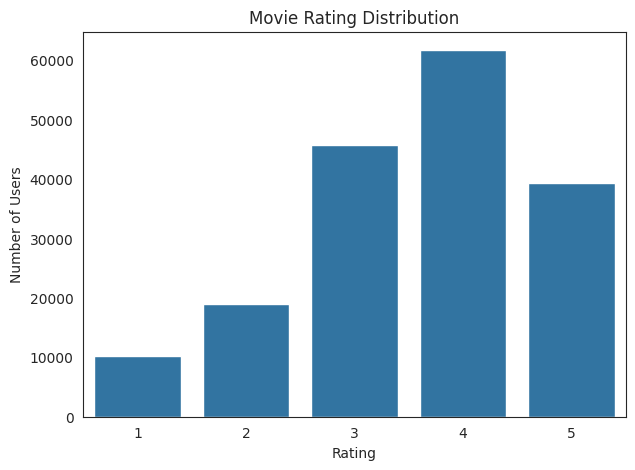

In [ ]:
plt.figure(figsize=(7, 5))
sns.countplot(x='Rating', data=data)
plt.title('Movie Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Number of Users')
plt.show()

#### **Distribution by Age -**

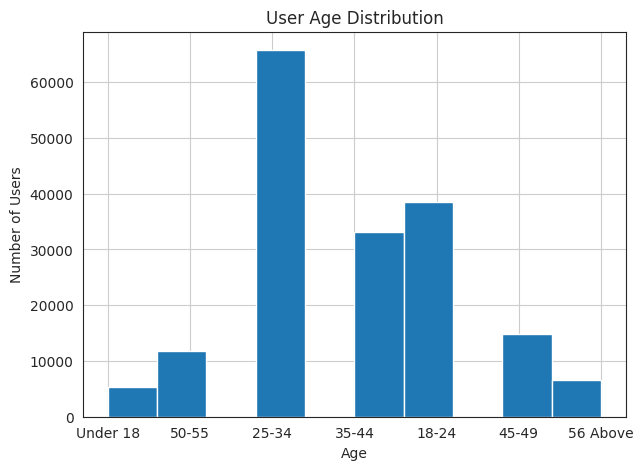

In [ ]:
data['Age'].hist(figsize=(7, 5))
plt.title('User Age Distribution')
plt.xlabel('Age')
plt.ylabel('Number of Users')
plt.show()

#### **Distribution by Gender -**

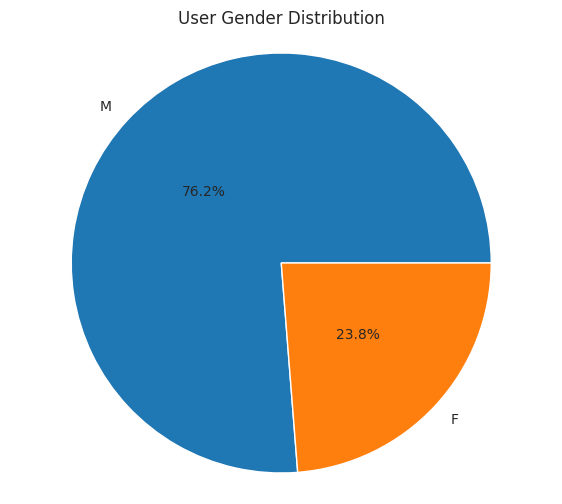

M    134060
F     41761
Name: Gender, dtype: int64

In [ ]:
x = data['Gender'].value_counts().values
plt.figure(figsize=(7, 6))
plt.pie(x, center=(0, 0), radius=1.5, labels=['M','F'], autopct='%1.1f%%', pctdistance=0.5)
plt.title('User Gender Distribution')
plt.axis('equal')
plt.show()
data['Gender'].value_counts()

#### **Distribution by Occupation -**

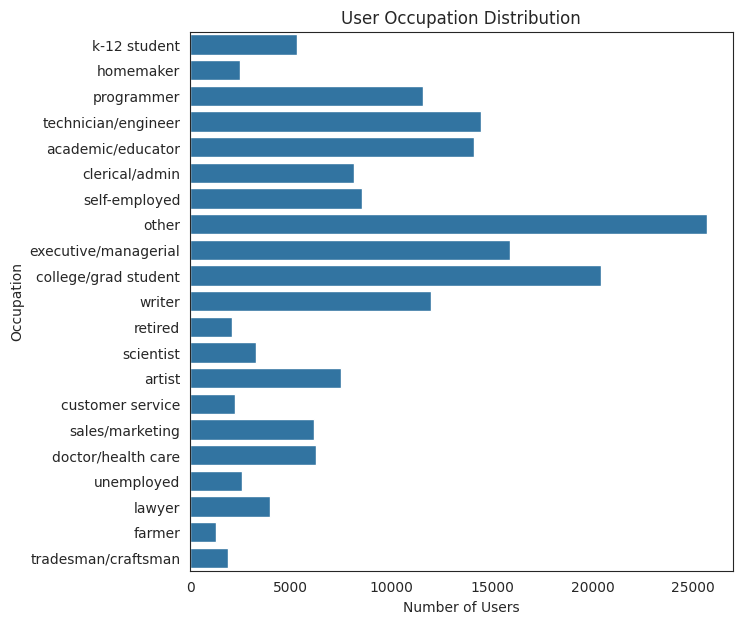

In [ ]:
plt.figure(figsize=(7, 7))
sns.countplot(y='Occupation', data=data)
plt.title('User Occupation Distribution')
plt.xlabel('Number of Users')
plt.ylabel('Occupation')
plt.show()

#### **Distribution by Release Year -**

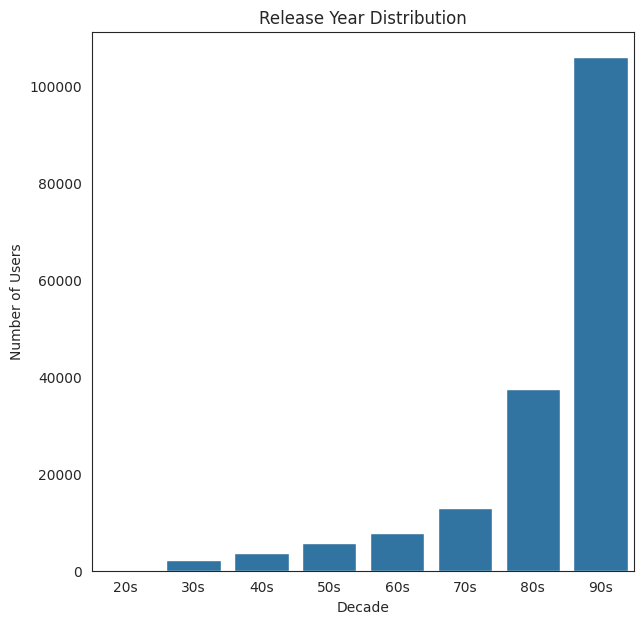

In [ ]:
plt.figure(figsize=(7, 7))
sns.countplot(x='ReleaseDec', data=data)
plt.title('Release Year Distribution')
plt.xlabel('Decade')
plt.ylabel('Number of Users')
plt.show()

### Grouping the data -

#### **Average rating -**

In [ ]:
data.groupby('Title')['Rating'].mean().sort_values(ascending=False).head(10)

Title
Eighth Day, The (Le Huitième jour )      5.00
Whatever Happened to Aunt Alice?         5.00
Curdled                                  5.00
I Stand Alone (Seul contre tous)         5.00
Hour of the Pig, The                     5.00
Criminal Lovers (Les Amants Criminels)   5.00
Dancemaker                               5.00
Gate of Heavenly Peace, The              5.00
Autumn Sonata (Höstsonaten )             5.00
Secret Agent                             5.00
Name: Rating, dtype: float64

#### **No. of ratings -**

In [ ]:
data.groupby('Title')['Rating'].count().sort_values(ascending=False).head(10)

Title
American Beauty                                   659
Star Wars: Episode V - The Empire Strikes Back    549
Star Wars: Episode IV - A New Hope                539
Jurassic Park                                     538
Star Wars: Episode VI - Return of the Jedi        537
Saving Private Ryan                               505
Matrix, The                                       491
Terminator 2: Judgment Day                        484
Men in Black                                      480
Silence of the Lambs, The                         473
Name: Rating, dtype: int64

In [ ]:
df = pd.DataFrame(data.groupby('Title')['Rating'].agg([('Avg rating', 'mean')]))
df['No. of ratings'] = pd.DataFrame(data.groupby('Title')['Rating'].count())

In [ ]:
df.sample(10)

Avg rating  No. of ratings
Title                                                   
Kronos                              3.10              20
Raise the Titanic                   2.89               9
Carnal Knowledge                    3.60              20
Bird on a Wire                      2.54              70
My Crazy Life (Mi vida loca)        4.12               8
Outrageous Fortune                  2.69              32
Jerry Springer: Ringmaster          1.62              13
Big One, The                        4.00              20
Iron Eagle                          2.51              37
House on Haunted Hill, The          2.33              63

In our case, we'll be working on a Collaborative Filtering Recommender System.

Collaborative filtering methods are classified as *memory-based* and *model-based*.

Also there are two approaches to this method. A *user-based* approach and an *item-based* approach.

### Pivot Table -

Creating a pivot table of movie titles and userid -

In [ ]:
mat = pd.pivot_table(data, index='UserID', columns='Title', values='Rating', aggfunc='mean')
mat.head(10)

Title   $1,000,000 Duck  'Night Mother  'Til There Was You  'burbs, The  \
UserID                                                                    
1                   NaN            NaN                 NaN          NaN   
10                  NaN            NaN                 NaN         4.00   
100                 NaN            NaN                 NaN          NaN   
1000                NaN            NaN                 NaN          NaN   
1001                NaN            NaN                 NaN          NaN   
1002                NaN            NaN                 NaN          NaN   
1003                NaN            NaN                 NaN          NaN   
1004                NaN            NaN                 NaN          NaN   
1005                NaN            NaN                 NaN          NaN   
1006                NaN            NaN                 NaN          NaN   

Title   ...And Justice for All  10 Things I Hate About You  101 Dalmatians  \
UserID                                                                       
1                          NaN                         NaN             NaN   
10                         NaN                         NaN             NaN   
100                        NaN                         NaN             NaN   
1000                       NaN                         NaN            4.00   
1001                       NaN                         NaN            3.00   
1002                       NaN                         NaN             NaN   
1003                       NaN                         NaN             NaN   
1004                       NaN                         NaN            4.00   
1005                       NaN                         NaN             NaN   
1006                       NaN                         NaN             NaN   

Title   12 Angry Men  13th Warrior, The  187  2 Days in the Valley  20 Dates  \
UserID                                                                         
1                NaN                NaN  NaN                   NaN       NaN   
10              3.00               4.00  NaN                   NaN       NaN   
100              NaN                NaN  NaN                   NaN       NaN   
1000             NaN                NaN  NaN                   NaN       NaN   
1001             NaN                NaN  NaN                   NaN       NaN   
1002             NaN                NaN  NaN                   NaN       NaN   
1003             NaN                NaN  NaN                   NaN       NaN   
1004             NaN                NaN  NaN                   NaN       NaN   
1005             NaN                NaN  NaN                   NaN       NaN   
1006             NaN                NaN  NaN                   NaN       NaN   

Title   20,000 Leagues Under the Sea  200 Cigarettes  2001: A Space Odyssey  \
UserID                                                                        
1                                NaN             NaN                    NaN   
10                              4.00             NaN                   3.00   
100                              NaN             NaN                   4.00   
1000                             NaN             NaN                    NaN   
1001                             NaN            1.00                    NaN   
1002                             NaN             NaN                    NaN   
1003                             NaN             NaN                    NaN   
1004                             NaN            1.00                    NaN   
1005                             NaN             NaN                    NaN   
1006                             NaN             NaN                    NaN   

Title   2010  24-hour Woman  28 Days  3 Ninjas: High Noon On Mega Mountain  \
UserID                                                                       
1        NaN            NaN      NaN                                   NaN   
10       NaN      

Imputing 'NaN' values with Zero rating -

In [ ]:
mat.fillna(0, inplace=True)

In [ ]:
mat.shape

(1114, 3374)

#### **Item-based approach:**

We will take a movie name as an input from the user and see which other 5 (five) movies have maximum correlation with it.

In [ ]:
movie_name = input("Enter a movie name: ")
movie_rating = mat[movie_name]

Enter a movie name: Liar Liar


In [ ]:
similar_movies = mat.corrwith(movie_rating)

In [ ]:
sim_df = pd.DataFrame(similar_movies, columns=['Correlation'])
sim_df.sort_values('Correlation', ascending=False, inplace=True)

In [ ]:
sim_df.iloc[1: , :].head()

Correlation
Title                                  
Mrs. Doubtfire                     0.53
Dumb & Dumber                      0.49
Ace Ventura: Pet Detective         0.46
Wedding Singer, The                0.45
Mask, The                          0.45

In [ ]:
item_sim = cosine_similarity(mat.T)
item_sim

array([[1.        , 0.        , 0.        , ..., 0.03380498, 0.1118034 ,
        0.        ],
       [0.        , 1.        , 0.0500278 , ..., 0.04990846, 0.        ,
        0.04915759],
       [0.        , 0.0500278 , 1.        , ..., 0.04827167, 0.        ,
        0.03356148],
       ...,
       [0.03380498, 0.04990846, 0.04827167, ..., 1.        , 0.10078697,
        0.25738837],
       [0.1118034 , 0.        , 0.        , ..., 0.10078697, 1.        ,
        0.        ],
       [0.        , 0.04915759, 0.03356148, ..., 0.25738837, 0.        ,
        1.        ]])

#### **Item similarity matrix -**

In [ ]:
item_sim_mat = pd.DataFrame(item_sim, index=mat.columns, columns=mat.columns)
item_sim_mat.head()

Title                   $1,000,000 Duck  'Night Mother  'Til There Was You  \
Title                                                                        
$1,000,000 Duck                    1.00           0.00                0.00   
'Night Mother                      0.00           1.00                0.05   
'Til There Was You                 0.00           0.05                1.00   
'burbs, The                        0.01           0.02                0.09   
...And Justice for All             0.00           0.05                0.03   

Title                   'burbs, The  ...And Justice for All  \
Title                                                         
$1,000,000 Duck                0.01                    0.00   
'Night Mother                  0.02                    0.05   
'Til There Was You             0.09                    0.03   
'burbs, The                    1.00                    0.12   
...And Justice for All         0.12                    1.00   

Title                   10 Things I Hate About You  101 Dalmatians  \
Title                                                                
$1,000,000 Duck                               0.11            0.22   
'Night Mother                                 0.03            0.14   
'Til There Was You                            0.12            0.18   
'burbs, The                                   0.20            0.23   
...And Justice for All                        0.10            0.17   

Title                   12 Angry Men  13th Warrior, The  187  \
Title                                                          
$1,000,000 Duck                 0.03               0.05 0.00   
'Night Mother                   0.02               0.01 0.00   
'Til There Was You              0.13               0.05 0.00   
'burbs, The                     0.22               0.21 0.16   
...And Justice for All          0.22               0.10 0.13   

Title                   2 Days in the Valley  20 Dates  \
Title                                                    
$1,000,000 Duck                         0.00      0.00   
'Night Mother                           0.06      0.00   
'Til There Was You                      0.02      0.15   
'burbs, The                             0.23      0.04   
...And Justice for All                  0.20      0.13   

Title                   20,000 Leagues Under the Sea  200 Cigarettes  \
Title                                                                  
$1,000,000 Duck                                 0.13            0.02   
'Night Mother                                   0.04            0.10   
'Til There Was You                              0.03            0.17   
'burbs, The                                     0.19            0.20   
...And Justice for All                          0.12            0.20   

Title                   2001: A Space Odyssey  2010  24-hour Woman  28 Days  \
Title                                                                         
$1,000,000 Duck                          0.04  0.00           0.00     0.08   
'Night Mother                            0.05  0.08           0.00     0.02   
'Til There Was You                       0.08  0.03           0.18     0.09   
'burbs, The                              0.19  0.16           0.06     0.20   
...And Justice for All                   0.18  0.13           0.00     0.13   

Title                   3 Ninjas: High Noon On Mega Mountain  301, 302  \
Title                                                                    
$1,000,000 Duck                                         0.00      0.00   
'Night Mother                                           0.00      0.00   
'Til There Was You                                      0.00      0.15   
'burbs, The                                             0.03      0.07   
...And Justice for All                                  0.00      0.00   

Title                   39 Steps, The  \
Title                                   
$1,0

In [ ]:
user_sim = cosine_similarity(mat)
user_sim

array([[1.        , 0.25531859, 0.12396703, ..., 0.15926709, 0.11935626,
        0.12239079],
       [0.25531859, 1.        , 0.25964457, ..., 0.16569953, 0.13332665,
        0.24845029],
       [0.12396703, 0.25964457, 1.        , ..., 0.20430203, 0.11352239,
        0.30693676],
       ...,
       [0.15926709, 0.16569953, 0.20430203, ..., 1.        , 0.18657496,
        0.18563871],
       [0.11935626, 0.13332665, 0.11352239, ..., 0.18657496, 1.        ,
        0.10827118],
       [0.12239079, 0.24845029, 0.30693676, ..., 0.18563871, 0.10827118,
        1.        ]])

#### **User similarity matrix -**

In [ ]:
user_sim_mat = pd.DataFrame(user_sim, index=mat.index, columns=mat.index)
user_sim_mat.head()

UserID    1   10  100  1000  1001  1002  1003  1004  1005  1006  1007  1008  \
UserID                                                                        
1      1.00 0.26 0.12  0.21  0.14  0.11  0.12  0.18  0.10  0.05  0.06  0.10   
10     0.26 1.00 0.26  0.28  0.16  0.11  0.14  0.43  0.19  0.10  0.16  0.22   
100    0.12 0.26 1.00  0.31  0.08  0.11  0.36  0.24  0.17  0.10  0.06  0.04   
1000   0.21 0.28 0.31  1.00  0.10  0.05  0.20  0.36  0.33  0.13  0.04  0.08   
1001   0.14 0.16 0.08  0.10  1.00  0.16  0.05  0.15  0.14  0.13  0.02  0.08   

UserID  1009  101  1010  1011  1012  1013  1014  1015  1016  1017  1018  1019  \
UserID                                                                          
1       0.05 0.03  0.16  0.08  0.08  0.05  0.20  0.18  0.13  0.15  0.18  0.11   
10      0.12 0.21  0.35  0.20  0.15  0.16  0.16  0.39  0.20  0.29  0.24  0.33   
100     0.06 0.35  0.26  0.14  0.09  0.02  0.29  0.20  0.17  0.15  0.34  0.19   
1000    0.12 0.28  0.25  0.12  0.12  0.05  0.18  0.22  0.09  0.20  0.36  0.20   
1001    0.20 0.07  0.25  0.07  0.04  0.07  0.06  0.30  0.29  0.10  0.07  0.17   

UserID  102  1020  1021  1022  1023  1024  1025  1026  1027  1028  1029  103  \
UserID                                                                         
1      0.12  0.03  0.09  0.12  0.10  0.02  0.03  0.00  0.14  0.05  0.19 0.03   
10     0.16  0.11  0.19  0.11  0.13  0.14  0.08  0.04  0.15  0.08  0.30 0.15   
100    0.01  0.18  0.20  0.07  0.09  0.07  0.07  0.03  0.21  0.10  0.16 0.22   
1000   0.10  0.14  0.17  0.06  0.05  0.02  0.12  0.03  0.15  0.07  0.22 0.17   
1001   0.18  0.15  0.10  0.27  0.05  0.07  0.12  0.13  0.08  0.05  0.15 0.10   

UserID  1030  1031  1032  1033  1034  1035  1036  1037  1038  1039  104  1040  \
UserID                                                                          
1       0.05  0.06  0.18  0.03  0.19  0.14  0.14  0.02  0.18  0.03 0.05  0.17   
10      0.24  0.27  0.23  0.20  0.33  0.13  0.17  0.05  0.18  0.06 0.09  0.33   
100     0.40  0.39  0.09  0.14  0.16  0.22  0.19  0.05  0.13  0.00 0.03  0.23   
1000    0.34  0.32  0.14  0.13  0.23  0.13  0.13  0.06  0.09  0.00 0.07  0.23   
1001    0.09  0.08  0.23  0.10  0.15  0.10  0.08  0.20  0.16  0.08 0.13  0.13   

UserID  1041  1042  1043  1044  1045  1046  1047  1048  1049  105  1050  1051  \
UserID                                                                          
1       0.05  0.08  0.08  0.14  0.06  0.03  0.14  0.15  0.07 0.10  0.14  0.25   
10      0.07  0.25  0.10  0.22  0.10  0.13  0.26  0.10  0.11 0.15  0.28  0.46   
100     0.08  0.05  0.09  0.19  0.00  0.09  0.26  0.14  0.18 0.26  0.16  0.21   
1000    0.04  0.05  0.06  0.26  0.04  0.09  0.20  0.05  0.09 0.45  0.14  0.24   
1001    0.08  0.02  0.06  0.02  0.14  0.05  0.14  0.19  0.14 0.05  0.37  0.31   

UserID  1052  1053  1054  1055  1056  1057  1058  1059  106  1060  1061  1062  \
UserID                                                                          
1       0.06  0.05  0.05  0.14  0.06  0.21  0.12  0.21 0.05  0.00  0.18  0.15   
10      0.14  0.19  0.23  0.20  0.14  0.30  0.34  0.34 0.17  0.11  0.16  0.29   
100     0.05  0.27  0.11  0.05  0.04  0.26  0.32  0.21 0.09  0.11  0.05  0.08   
1000    0.02  0.33  0.15  0.11  0.16  0.29  0.28  0.21 0.06  0.10  0.20  0.20   
1001    0.05  0.15  0.13  0.17  0.04  0.17  0.25  0.24 0.07  0.13  0.08  0.12   

UserID  1063  1064  1065  1066  1067  1068  1069  107  1070  1071  1072  1073  \
UserID                                                                          
1       0.10  0.12  0.03  0.10  0.12  0.24  0.03 0.12  0.04  0.07  0.23  0.07   
10      0.25  0.20  0.13  0.28  0.19  0.39  0.12 0.19  0.02  0.19  0.24  0.17   
100     0.26  0.17  0.03  0.20  0.18  0.19  0.10 0.17  0.13  0.19  0.17  0.13   
1000    0.30  0.15  0.01  0.14  0.11  0.18  0.04 0.13  0.04  0.11  0.17  0.09   
1001    0.14  0.24  0.21  0.13  0.17  0.23  0.29 0.04  0.08  0.12  0.15  0.11   

UserID  1074  1075  1076  1077  1078  1079  1

### Nearest Neighbors -

In [ ]:
csr_mat = sparse.csr_matrix(mat.T.values)
csr_mat

<3374x1114 sparse matrix of type '<class 'numpy.float64'>'
	with 175285 stored elements in Compressed Sparse Row format>

Fitting the model with 'cosine similarity' as the distance metric and 5 (five) as the no. of nearest neighbors.

In [ ]:
knn = NearestNeighbors(n_neighbors=5, metric='cosine', n_jobs=-1)
knn.fit(csr_mat)

NearestNeighbors(metric='cosine', n_jobs=-1)

Let's make recommendations for a movie of the user's choice -

In [ ]:
movie_name = input("Enter a movie name: ")
movie_index = mat.columns.get_loc(movie_name)

Enter a movie name: Liar Liar


In [ ]:
distances, indices = knn.kneighbors(mat[movie_name].values.reshape(1, -1), n_neighbors = 11)

In [ ]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for the movie: {0}\n'.format(movie_name))
    else:
        print('{0}: {1}, with distance of {2}'.format(i, mat.columns[indices.flatten()[i]], round(distances.flatten()[i], 3)))

Recommendations for the movie: Liar Liar

1: Mrs. Doubtfire, with distance of 0.417
2: Dumb & Dumber, with distance of 0.458
3: Mask, The, with distance of 0.477
4: Ace Ventura: Pet Detective, with distance of 0.481
5: Wedding Singer, The, with distance of 0.482
6: Wayne's World, with distance of 0.485
7: League of Their Own, A, with distance of 0.49
8: Austin Powers: International Man of Mystery, with distance of 0.495
9: Home Alone, with distance of 0.501
10: My Cousin Vinny, with distance of 0.501


Let's compare our result with google recomm:

### Matrix Factorization -

First we need to create embeddings for both the user as well as the item or movie. For this We have used the Embedding layer from keras.

Creating embeddings for both users and movies -

In [ ]:
users = data.UserID.unique()
movies = data.MovieID.unique()

userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

The number of dimensions (Latent Factors) in the embeddings is a hyperparameter to deal with in this implementation of Collaborative Filtering.

In [ ]:
data['UserID'] = data['UserID'].apply(lambda x: userid2idx[x])
data['MovieID'] = data['MovieID'].apply(lambda x: movieid2idx[x])
split = np.random.rand(len(data)) < 0.8
train = data[split]
valid = data[~split]
print(train.shape, valid.shape)

(140686, 13) (35135, 13)


In [ ]:
n_movies = len(data['MovieID'].unique())
n_users = len(data['UserID'].unique())

n_latent_factors = 64  # Hyperparamter

Specify the input expected to be embedded (Both in user and item embedding). Then use a Embedding layer which expects the number of latent factors in the resulting embedding and also the number of users or items.

In [ ]:
user_input = Input(shape=(1, ), name='user_input', dtype='int64')

In [ ]:
user_embedding = Embedding(n_users, n_latent_factors, name='user_embedding')(user_input)

In [ ]:
user_vec = Flatten(name='FlattenUsers')(user_embedding)

In [ ]:
movie_input = Input(shape=(1, ), name='movie_input', dtype='int64')
movie_embedding = Embedding(n_movies, n_latent_factors, name='movie_embedding')(movie_input)
movie_vec = Flatten(name='FlattenMovies')(movie_embedding)

Then we take the 'Dot-Product' of both the embeddings using the 'merge' layer. Note that 'dot-product' is just a measure of simalrity and we can use any other mode like 'mulitply' or 'cosine simalarity' or 'concatenate' etc.

In [ ]:
sim = dot([user_vec, movie_vec], name='Simalarity-Dot-Product', axes=1)
model = keras.models.Model([user_input, movie_input], sim)

Lastly we make a Keras model from the specified details.

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')

Let's see the model's summary -

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 movie_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding (Embedding)  (None, 1, 64)                71296     ['user_input[0][0]']          
                                                                                                  
 movie_embedding (Embedding  (None, 1, 64)                218560    ['movie_input[0][0]']         
 )                                                                                            

### Model Training -

In [ ]:
model_hist = model.fit([train.UserID, train.MovieID], train.Rating,
                       batch_size=128, epochs=20,
                       validation_data = ([valid.UserID, valid.MovieID], valid.Rating),
                       verbose=1)

Epoch 1/20
1100/1100 [==============================] - 12s 9ms/step - loss: 14.0226 - val_loss: 14.0667
Epoch 2/20
1100/1100 [==============================] - 4s 4ms/step - loss: 13.9963 - val_loss: 14.0177
Epoch 3/20
1100/1100 [==============================] - 5s 4ms/step - loss: 13.8111 - val_loss: 13.6245
Epoch 4/20
1100/1100 [==============================] - 4s 4ms/step - loss: 12.9583 - val_loss: 12.2357
Epoch 5/20
1100/1100 [==============================] - 4s 3ms/step - loss: 10.9946 - val_loss: 9.8068
Epoch 6/20
1100/1100 [==============================] - 4s 4ms/step - loss: 8.3516 - val_loss: 7.1229
Epoch 7/20
1100/1100 [==============================] - 5s 4ms/step - loss: 5.8692 - val_loss: 4.9431
Epoch 8/20
1100/1100 [==============================] - 4s 4ms/step - loss: 4.0862 - val_loss: 3.5485
Epoch 9/20
1100/1100 [==============================] - 4s 4ms/step - loss: 3.0156 - val_loss: 2.7333
Epoch 10/20
1100/1100 [==============================] - 4s 4ms/step - l

### Model Evaluation -

In [ ]:
y_pred = model.predict([valid.UserID, valid.MovieID], verbose=0)
y_pred_class = np.argmax(y_pred, axis=-1)

Calculating the RMSE -

In [ ]:
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(valid.Rating, y_pred, squared=False)
print('Root Mean Squared Error: {:.3f}'.format(rmse))

Root Mean Squared Error: 0.990


Calculating the MAPE -

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
mape =  mean_absolute_percentage_error(valid.Rating, y_pred)
print('Mean Absolute Percentage Error: {:.3f}'.format(mape))

Mean Absolute Percentage Error: 0.293


Plotting the Model Loss -

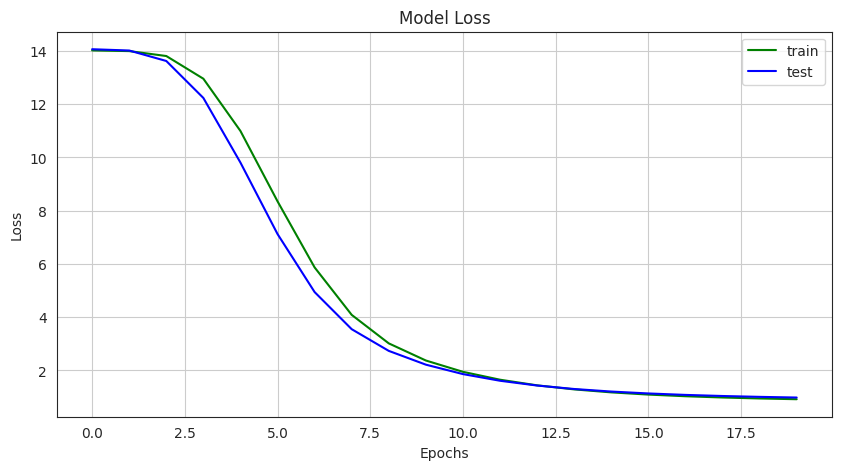

In [ ]:
rcParams['figure.figsize'] = 10, 5
plt.plot(model_hist.history['loss'] , 'g')
plt.plot(model_hist.history['val_loss'] , 'b')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.grid(True)
plt.show()

#### **User-based approach:**

We've given our user 4 (four) movie names and asked them to rate these movies according to their liking.

In [ ]:
mov_name = ['Mrs. Doubtfire', 'Dumb & Dumber', 'Ace Ventura: Pet Detective', 'Home Alone']

In [ ]:
mov_id = []
for mov in mov_name:
    id = data[data['Title'] == mov]['MovieID'].iloc[0]
    mov_id.append(id)

In [ ]:
mov_rating = list(map(int, input("Rate these movies respectively: ").split()))

Rate these movies respectively: 3 4 5 5


Creating a dataframe for a new user's choices.

In [ ]:
user_choices = pd.DataFrame({'MovieID': mov_id,
                            'Title': mov_name,
                            'Rating': mov_rating})
user_choices.sort_values(by='MovieID')

MovieID                       Title  Rating
2      316  Ace Ventura: Pet Detective       5
3      328                  Home Alone       5
1      978               Dumb & Dumber       4
0     1009              Mrs. Doubtfire       3

Users who have watched the same movies as the new users.

In [ ]:
other_users = data[data['MovieID'].isin(user_choices['MovieID'].values)]
other_users = other_users[['UserID', 'MovieID', 'Rating']]
other_users['UserID'].nunique()

263

Sorting old users by the count of most movies in common with the new user.

In [ ]:
common_movies = other_users.groupby(['UserID'])
common_movies = sorted(common_movies, key=lambda x: len(x[1]), reverse=True)
common_movies[0]

(9,
       UserID  MovieID  Rating
 1687       9      978       1
 1705       9      316       1
 1738       9     1009       3
 1749       9      328       2)

In [ ]:
top_users = common_movies[:100]

Calculating a Similarity Score for each user using Pearson Correlation function -

In [ ]:
pearson_corr = {}

for user_id, movies in top_users:
    movies = movies.sort_values(by='MovieID')
    movie_list = movies['MovieID'].values

    new_user_ratings = user_choices[user_choices['MovieID'].isin(movie_list)]['Rating'].values
    user_ratings = movies[movies['MovieID'].isin(movie_list)]['Rating'].values

    corr = pearsonr(new_user_ratings, user_ratings)
    pearson_corr[user_id] = corr[0]

Get top 10 users with the highest similarity indices.

In [ ]:
pearson_df = pd.DataFrame(columns=['UserID', 'Similarity Index'], data=pearson_corr.items())
pearson_df = pearson_df.sort_values(by='Similarity Index', ascending=False)[:10]
pearson_df

UserID  Similarity Index
98     115              1.00
90      48              1.00
88      39              1.00
66     296              1.00
58     231              1.00
69     343              0.98
75     420              0.94
38     545              0.87
2       72              0.87
70     347              0.87

Get all movies for these users and add weighted movie ratings.

In [ ]:
users_rating = pearson_df.merge(data, on='UserID', how='inner')
users_rating['Weighted Rating'] = users_rating['Rating'] * users_rating['Similarity Index']
users_rating = users_rating[['UserID', 'MovieID', 'Rating', 'Similarity Index', 'Weighted Rating']]
users_rating

UserID  MovieID  Rating  Similarity Index  Weighted Rating
0        115        0       5              1.00             5.00
1        115      964       4              1.00             4.00
2        115      845       4              1.00             4.00
3        115     1389       3              1.00             3.00
4        115      120       4              1.00             4.00
...      ...      ...     ...               ...              ...
6054     347     2926       3              0.87             2.60
6055     347      295       5              0.87             4.33
6056     347     1555       5              0.87             4.33
6057     347     2264       3              0.87             2.60
6058     347      962       4              0.87             3.46

[6059 rows x 5 columns]

Calculating average recommendation score and selecting items with the highest score.

In [ ]:
# Calculate sum of similarity index and weighted rating for each movie
grouped_ratings = users_rating.groupby('MovieID').sum()[['Similarity Index', 'Weighted Rating']]

recommend_movies = pd.DataFrame()

# Add average recommendation score.
# We're calculating average recommendation score by dividing the Weighted Rating by the Similarity Index.
recommend_movies['avg_reccomend_score'] = grouped_ratings['Weighted Rating']/grouped_ratings['Similarity Index']
recommend_movies['MovieID'] = grouped_ratings.index
recommend_movies = recommend_movies.reset_index(drop=True)

# Select movies with the highest score i.e. 5
recommend_movies = recommend_movies[(recommend_movies['avg_reccomend_score'] == 5)]

Let's see 10 movies recommended based on the ratings given by old users who are similar to the new user.

In [ ]:
recommendations = data[data['MovieID'].isin(recommend_movies['MovieID'])][['MovieID', 'Title']].sample(10)
recommendations

MovieID                Title
103944     1154              Henry V
155822     2016   Dancer in the Dark
19823       733         Best in Show
43217       294  Remember the Titans
140820      420               Carrie
104867       12       Close Shave, A
74236      1217                 Diva
45621      2373         Paris, Texas
74705      2068    Carnival of Souls
91135      2369     Jean de Florette